<a href="https://colab.research.google.com/github/Chaddol/AI_ML/blob/main/%EA%B2%BD%EA%B5%AC%EC%95%BD%EC%A0%9C_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import json
from keras import layers

## 데이터 안의 혈압약 찾기
- 몇 번 압축파일에 혈압약이 있는지 찾기
- 4TB의 데이터 중 필요한 dataset 하나만 사용할 예정 (최소 18GB)
- 혈압약 코드 찾기

In [ ]:
dirs = 'C:/Users/Chaddol/Downloads/166.약품식별 인공지능 개발을 위한 경구약제 이미지 데이터/01.데이터/1.Training/라벨링데이터/단일경구약제 5000종'
# dirs = dirs.replace('\\', '/', 10)
dirs_in = glob.glob(dirs + '/*')
print(len(dirs_in), type(dirs_in))
set_name = []
for s in dirs_in:  #set_name 은 TL_00_단일 이런 형식
    set_name += glob.glob(s + '/*')

# print(set_name[:10])
# print(dirs_in[:10])


0 <class 'list'>


In [ ]:
files = []
check = []
data_set = []
for name in set_name:
    files = glob.glob(name + '/*')
    f = files[0]
    check.append(f)
# print(check[:10])


In [ ]:
len('C:/Users/Chaddol/Downloads/166.약품식별 인공지능 개발을 위한 경구약제 이미지 데이터/01.데이터/1.Training/라벨링데이터/단일경구약제 5000종\\'), len('\\K-019469_json\\K-019469_0_0_0_0_60_000_200.json')

(99, 47)

In [ ]:
bp_drug_names = []
for file in check:
    with open(file, 'r', encoding='UTF-8') as j:
        js = json.load(j)
        di_class = js['images'][0]['di_class_no']
        if di_class == "[02140]혈압강하제": # 여기에 코드와 약 종류를 입력하면 (json 파일의 di_class_no) 찾아준다. f 에 해당하는 파일이 없는 폴더도 존재하기 때문.
            target = js['images'][0]['file_name'][:8]
            bp_drug_names.append(target)
            data_set_name = file[99:107]
            data_set.append(data_set_name.strip('\\'))
            # print(file)

In [ ]:
bp_drug_dataset = list(set(data_set))
bp_drug_dataset[0]

72

In [ ]:
bp_drug_names[:10], len(bp_drug_names)

(['K-019699',
  'K-019700',
  'K-019861',
  'K-019867',
  'K-020378',
  'K-020379',
  'K-020401',
  'K-020834',
  'K-020877',
  'K-023252'],
 420)

위 정보를 통해 혈압약이 들어 있는 압축 파일 중 가장 크기가 작은 81번 데이터 셋을 활용했습니다.

## 데이터 전처리
- 아래 코드는 전처리에 사용됩니다. 현재 용량이 너무 커서 원본을 삭제해서 동작하지 않습니다.
- bbox 데이터를 통해 crop을 진행하고 정사각형으로 resize하면 캡슐형 경구약제는 길쭉한 형태적 특성이 데이터에서 사라집니다.
- 이를 해결하기 위해 bbox의 (x, y, w, h)에서 max(w, h)를 한 변으로 하는 정사각형 모양으로 crop을 진행했습니다.

In [ ]:
dir_1 = glob.glob('Data/1.Training/labeling_data/drug/*')
json_names = []
for temp_dir in dir_1:
    json_names += glob.glob(temp_dir + '/*.*')
# print(json_names[:3])

temp_img_dir = glob.glob('Data/1.Training/raw_data/drug/*')
# print(len(temp_img_dir))
img_names = []
for temp in temp_img_dir:
    img_names += glob.glob(temp + '/*.*')

# print(img_names[:10])
i = 0
# os.mkdir('Data/1.Training/images/' + 'hi')
for idx, img_data in enumerate(json_names):
    img_data = img_data.replace('\\', '/', 10)
    # print(img_data)
    with open(img_data, 'r', encoding='UTF=8') as j:
        js = json.load(j)
        file_name = js['images'][0]['file_name']
        file_dir = 'Data/1.Training/images/' + file_name[:8]
        if not os.path.isdir(file_dir):
            os.mkdir(file_dir)

        file_dir = file_dir + '/' + file_name

        if not os.path.isfile(file_dir):
            # print(file_dir)
            x, y, w, h = js['annotations'][0]['bbox']

            cx = x + w // 2
            cy = y + h // 2
            w_h, h_h = max(w, h), max(w, h)  # 깨끗한 data 를 얻기 위해 크롭영역을 정방형으로 해준다. 기준은 둘 중 큰 값
            x = cx - (w_h // 2)
            y = cy - (h_h // 2)

            # print(x, y, w, h)
            img_names[idx] = img_names[idx].replace('\\', '/', 10)
            # print(img_names[idx])
            img = cv2.imread(img_names[idx], cv2.IMREAD_COLOR)
            cropped_img = img[y:y + h_h, x:x + w_h]
            cropped_img = cv2.resize(cropped_img, (64, 64))
            if idx % 100 == 0:
                print('진행상황: {} / {}'.format(idx, len(img_names)))
            cv2.imwrite(file_dir, cropped_img)
        else:
            print('이미 처리한 데이터 입니다.')
            continue


In [ ]:
mother_dir = 'images/'
folder_list = os.listdir(mother_dir)

In [ ]:
img_file_names = []
for x in folder_list:
  img_file_names += glob.glob(mother_dir + '/' + x + '/*.*')

print(len(img_file_names))
for i in range(10):
  print(img_file_names[i]) 

9612
images//K-038884\K-038884_0_0_0_0_75_000_200.png
images//K-038884\K-038884_0_0_0_0_75_020_200.png
images//K-038884\K-038884_0_0_0_0_75_040_200.png
images//K-038884\K-038884_0_0_0_0_75_060_200.png
images//K-038884\K-038884_0_0_0_0_75_080_200.png
images//K-038884\K-038884_0_0_0_0_75_100_200.png
images//K-038884\K-038884_0_0_0_0_75_120_200.png
images//K-038884\K-038884_0_0_0_0_75_140_200.png
images//K-038884\K-038884_0_0_0_0_75_160_200.png
images//K-038884\K-038884_0_0_0_0_75_180_200.png


In [ ]:
cls = {}
for idx,folder in enumerate(folder_list):
  cls[folder] = idx

cls

{'K-038884': 0,
 'K-038890': 1,
 'K-038896': 2,
 'K-038910': 3,
 'K-038912': 4,
 'K-038913': 5,
 'K-038914': 6,
 'K-038927': 7,
 'K-038929': 8,
 'K-038954': 9,
 'K-038958': 10,
 'K-038959': 11,
 'K-038962': 12,
 'K-038967': 13,
 'K-038970': 14,
 'K-039021': 15,
 'K-039036': 16,
 'K-039047': 17,
 'K-039104': 18,
 'K-039108': 19,
 'K-039123': 20,
 'K-039136': 21,
 'K-039146': 22,
 'K-039147': 23}

In [ ]:
x_train_names, x_test_names = train_test_split(img_file_names, test_size=0.2, random_state=1)
x_train_names[:10]

['images//K-038929\\K-038929_0_0_0_1_75_320_200.png',
 'images//K-038896\\K-038896_0_1_0_1_90_100_200.png',
 'images//K-039047\\K-039047_0_2_1_0_90_080_200.png',
 'images//K-038910\\K-038910_0_0_0_0_70_200_200.png',
 'images//K-039147\\K-039147_0_0_1_0_75_120_200.png',
 'images//K-039147\\K-039147_0_1_1_2_70_300_200.png',
 'images//K-039147\\K-039147_0_2_0_1_90_120_200.png',
 'images//K-038929\\K-038929_0_0_0_2_70_100_200.png',
 'images//K-039047\\K-039047_0_2_0_0_90_180_200.png',
 'images//K-039136\\K-039136_0_1_0_2_75_160_200.png']

In [ ]:
x_test_names, x_valid_names = train_test_split(x_test_names, test_size=0.5, random_state=1)

In [ ]:
s = 8

In [ ]:
x_train = []
y_train = []

for idx, x in enumerate(x_train_names):
  if idx % 1000 == 0:
    print('{} / {}'.format(idx, len(x_test_names)))
  img = cv2.cvtColor(cv2.imread(x, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
  id = x[s:s+8]
  temp_cls = cls[id]
  y_train.append(temp_cls)
  x_train.append(img)


x_train = np.array(x_train)
y_train = np.array(y_train)

0 / 961
1000 / 961
2000 / 961
3000 / 961
4000 / 961
5000 / 961
6000 / 961
7000 / 961


In [ ]:
# x_train = np.array(x_train)
x_train = np.array(x_train)/255
x_train[:3]

array([[[[0.41568627, 0.28627451, 0.21960784],
         [0.41568627, 0.2745098 , 0.23137255],
         [0.41568627, 0.2745098 , 0.21960784],
         ...,
         [0.39607843, 0.27843137, 0.22352941],
         [0.39607843, 0.28235294, 0.22745098],
         [0.38823529, 0.28627451, 0.21960784]],

        [[0.41568627, 0.28627451, 0.21568627],
         [0.41568627, 0.2745098 , 0.21960784],
         [0.41568627, 0.2745098 , 0.21960784],
         ...,
         [0.40784314, 0.27058824, 0.21176471],
         [0.41176471, 0.26666667, 0.21176471],
         [0.39607843, 0.27843137, 0.21960784]],

        [[0.41568627, 0.29411765, 0.21960784],
         [0.42352941, 0.29019608, 0.21960784],
         [0.42745098, 0.28235294, 0.21176471],
         ...,
         [0.39607843, 0.28235294, 0.22745098],
         [0.39607843, 0.27843137, 0.21960784],
         [0.40392157, 0.2745098 , 0.21176471]],

        ...,

        [[0.43529412, 0.29411765, 0.21960784],
         [0.42352941, 0.29019608, 0.22745098]

In [ ]:
y_train = y_train.reshape(-1,1)
y_train.shape

(7689, 1)

In [ ]:
x_test, y_test = [], []

for idx, x in enumerate(x_test_names):
  if idx % 100 == 0:
    print('{} / {}'.format(idx, len(x_test_names)))
  img = cv2.cvtColor(cv2.imread(x, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
  id = x[s:s+8]
  temp_cls = cls[id]
  y_test.append(temp_cls)
  x_test.append(img)


x_test = np.array(x_test)
y_test = np.array(y_test)

0 / 961
100 / 961
200 / 961
300 / 961
400 / 961
500 / 961
600 / 961
700 / 961
800 / 961
900 / 961


In [ ]:
x_test = x_test/255
y_test = y_test.reshape(-1,1)

In [ ]:
x_test.shape, y_test.shape

((961, 64, 64, 3), (961, 1))

In [ ]:
x_valid, y_valid = [], []

for idx, x in enumerate(x_valid_names):
  if idx % 100 == 0:
    print('{} / {}'.format(idx, len(x_valid_names)))
  img = cv2.cvtColor(cv2.imread(x, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
  id = x[s:s+8]
  temp_cls = cls[id]
  y_valid.append(temp_cls)
  x_valid.append(img)


x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

0 / 962
100 / 962
200 / 962
300 / 962
400 / 962
500 / 962
600 / 962
700 / 962
800 / 962
900 / 962


In [ ]:
x_valid = x_valid/255
y_valid = y_valid.reshape((-1,1))

In [ ]:
saved_model = './drug.h5'
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10,restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint(saved_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
model1 = tf.keras.models.Sequential()
#
model1.add(tf.keras.layers.Conv2D(64,3,padding='same',activation='relu',input_shape=(64,64,3)))  # conv2d 수행하면 64채널의 결과가 나오고, kernelsize = 3
model1.add(tf.keras.layers.Dropout(rate=0.5))                          #  DO1
model1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#
model1.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model1.add(tf.keras.layers.Dropout(rate=0.5))                          # DO2
model1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#
model1.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'))
model1.add(tf.keras.layers.Dropout(rate=0.5))                           # DO3
model1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#
model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dense(len(cls), activation='softmax'))
#
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 256)      

In [ ]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
               
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
history = model1.fit(x_train, y_train,
          epochs = 100,
          callbacks=[es, mc],
          batch_size = 32,
          validation_data = (x_test, y_test))

Epoch 1/100
241/241 [==============================] - 4s 16ms/step - loss: 1.7236 - accuracy: 0.4451 - val_loss: 2.1857 - val_accuracy: 0.5911

Epoch 00001: val_accuracy improved from -inf to 0.59105, saving model to .\drug.h5
Epoch 2/100
241/241 [==============================] - 4s 15ms/step - loss: 0.6063 - accuracy: 0.7718 - val_loss: 1.7847 - val_accuracy: 0.6327

Epoch 00002: val_accuracy improved from 0.59105 to 0.63267, saving model to .\drug.h5
Epoch 3/100
241/241 [==============================] - 4s 15ms/step - loss: 0.4829 - accuracy: 0.8045 - val_loss: 1.7133 - val_accuracy: 0.6087

Epoch 00003: val_accuracy did not improve from 0.63267
Epoch 4/100
241/241 [==============================] - 4s 15ms/step - loss: 0.4200 - accuracy: 0.8222 - val_loss: 1.6051 - val_accuracy: 0.6857

Epoch 00004: val_accuracy improved from 0.63267 to 0.68574, saving model to .\drug.h5
Epoch 5/100
241/241 [==============================] - 4s 15ms/step - loss: 0.3864 - accuracy: 0.8270 - val_lo

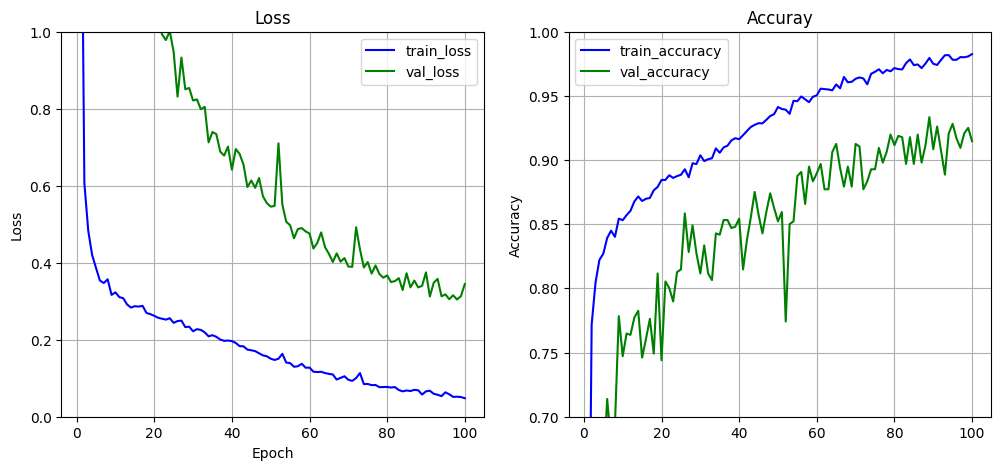

In [ ]:
loss = history.history['loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(epochs, history.history['loss'], 'b', label='train_loss')
plt.plot(epochs, history.history['val_loss'], 'g', label='val_loss')
plt.ylim([0,1.0])
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuray')
plt.plot(epochs, history.history['accuracy'], 'b', label='train_accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'g', label='val_accuracy')
plt.ylim([0.7,1])
plt.grid(True)
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
x_test.shape

(961, 64, 64, 3)

In [ ]:
y_out = model1.predict(x_valid)
y_out.shape

(962, 24)

In [ ]:
y_max = np.argmax(y_out, axis=1).reshape((-1,1))
y_max[:10], y_max.shape

(array([[ 4],
        [22],
        [17],
        [14],
        [21],
        [21],
        [22],
        [ 1],
        [23],
        [ 9]], dtype=int64),
 (962, 1))

In [ ]:
idx = (y_valid != y_max)

In [ ]:
wrong_list = []
for x, i in enumerate(idx):
    if i:
       wrong_list.append(x)
       
print('{:>2.3f} %'.format(100*(1 - (len(wrong_list) / len(y_valid)))))

91.372 %


83


IndexError: index 961 is out of bounds for axis 0 with size 961

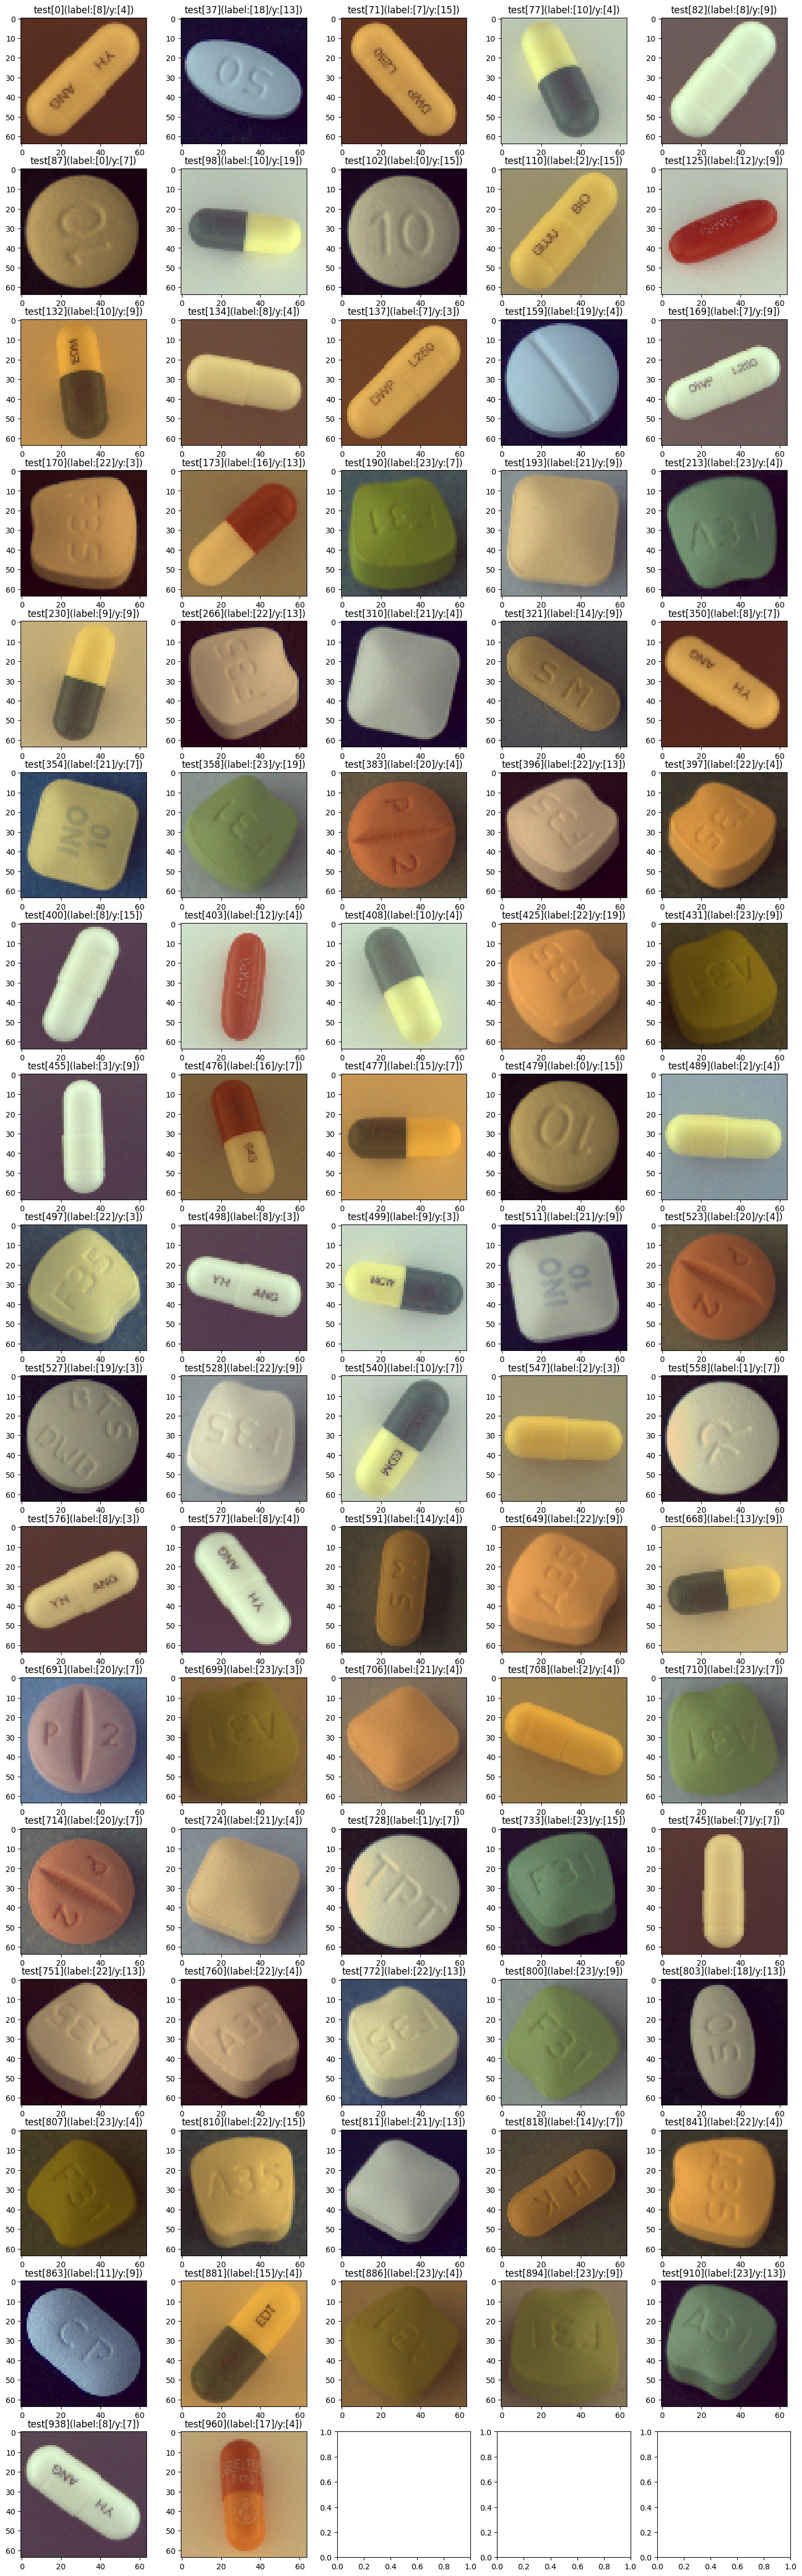

In [ ]:
print(len(wrong_list))
n_row = (len(wrong_list)-1) // 5 + 1
fig_result, ax_result = plt.subplots(n_row, 5, figsize=(18, 3.5*n_row))
for x,i in enumerate(wrong_list):
    ax_result[x//5,x%5].imshow(x_test[i])
    ax_result[x//5,x%5].set_title("test[{}](label:{}/y:{})".format(i, y_test[i], y_max[i]))

위 모델의 결과 98%의 정확도로 예측합니다. 하지만, overfitting이 의심됩니다.

데이터 증강을 통해 데이터 불균형을 해소해야 한다는 내용을 찾았으니 다음 프로젝트에서 적용해 보겠습니다.